# Workspace Initialization

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
from scipy import ndimage as ndi
from skimage import io
from skimage.exposure import rescale_intensity
from skimage.morphology import reconstruction
from skimage.feature import shape_index
from skimage.feature import match_template
from PIL import Image
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh

import matplotlib.pyplot as plt

# Parameter Updates
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.axisbelow'] = True
Image.MAX_IMAGE_PIXELS = None

# Import Image
image = io.imread('tiles/tile_16.png') 

# Image Preparation
[Source](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_holes_and_peaks.html#sphx-glr-auto-examples-features-detection-plot-holes-and-peaks-py)

In [7]:
# Create initial mask
seed = np.copy(image)
seed[1:-1, 1:-1] = image.max()
mask = image
filled = reconstruction(seed, mask, method='erosion')

# Image Examination
## Finding Holes

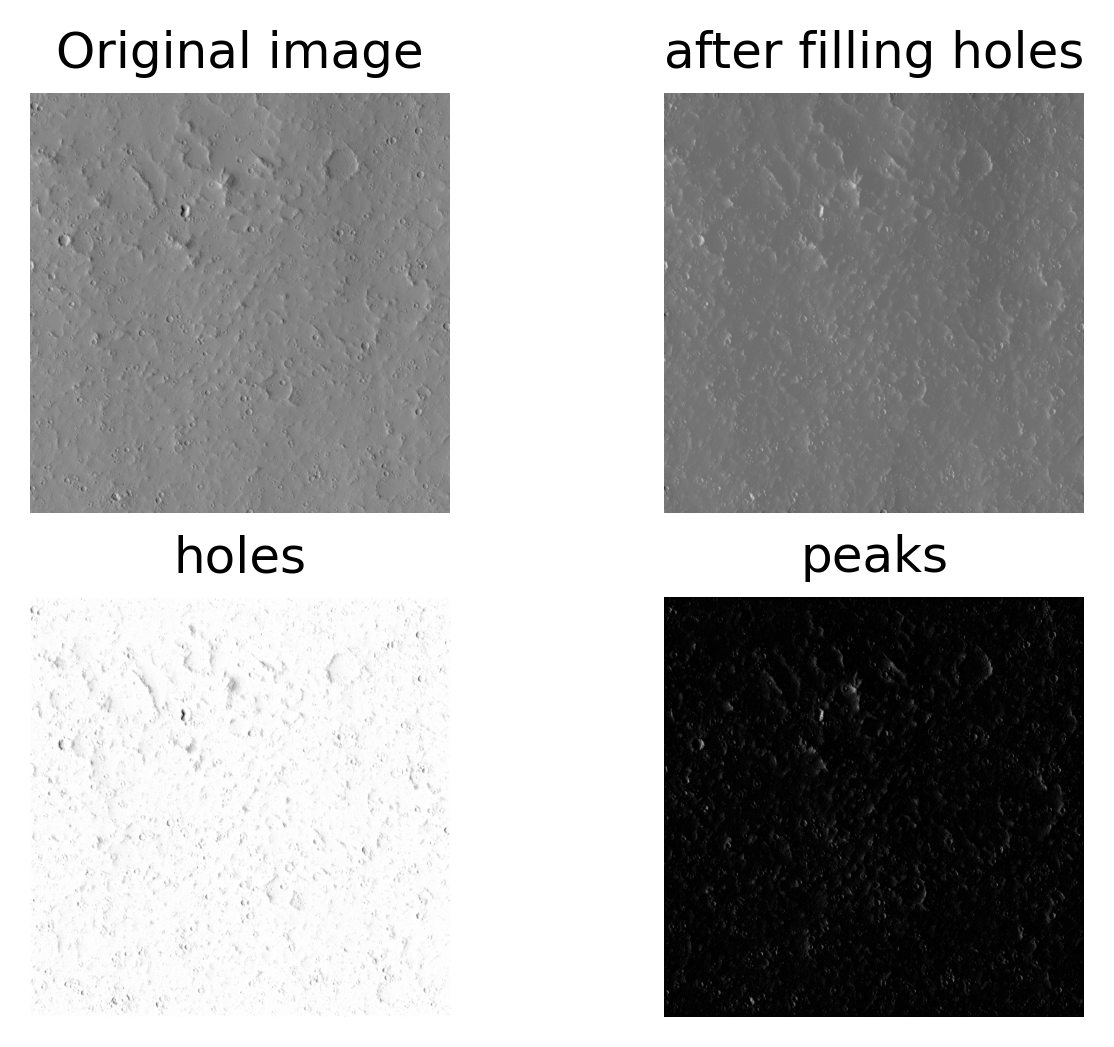

In [8]:
seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
rec = reconstruction(seed, mask, method='dilation')

fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(filled, cmap='gray')
ax[1].set_title('after filling holes')
ax[1].axis('off')

ax[2].imshow(image-filled, cmap='gray')
ax[2].set_title('holes')
ax[2].axis('off')

ax[3].imshow(image-rec, cmap='gray')
ax[3].set_title('peaks')
ax[3].axis('off')
plt.show()

## Shape Index
[Source](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_shape_index.html)

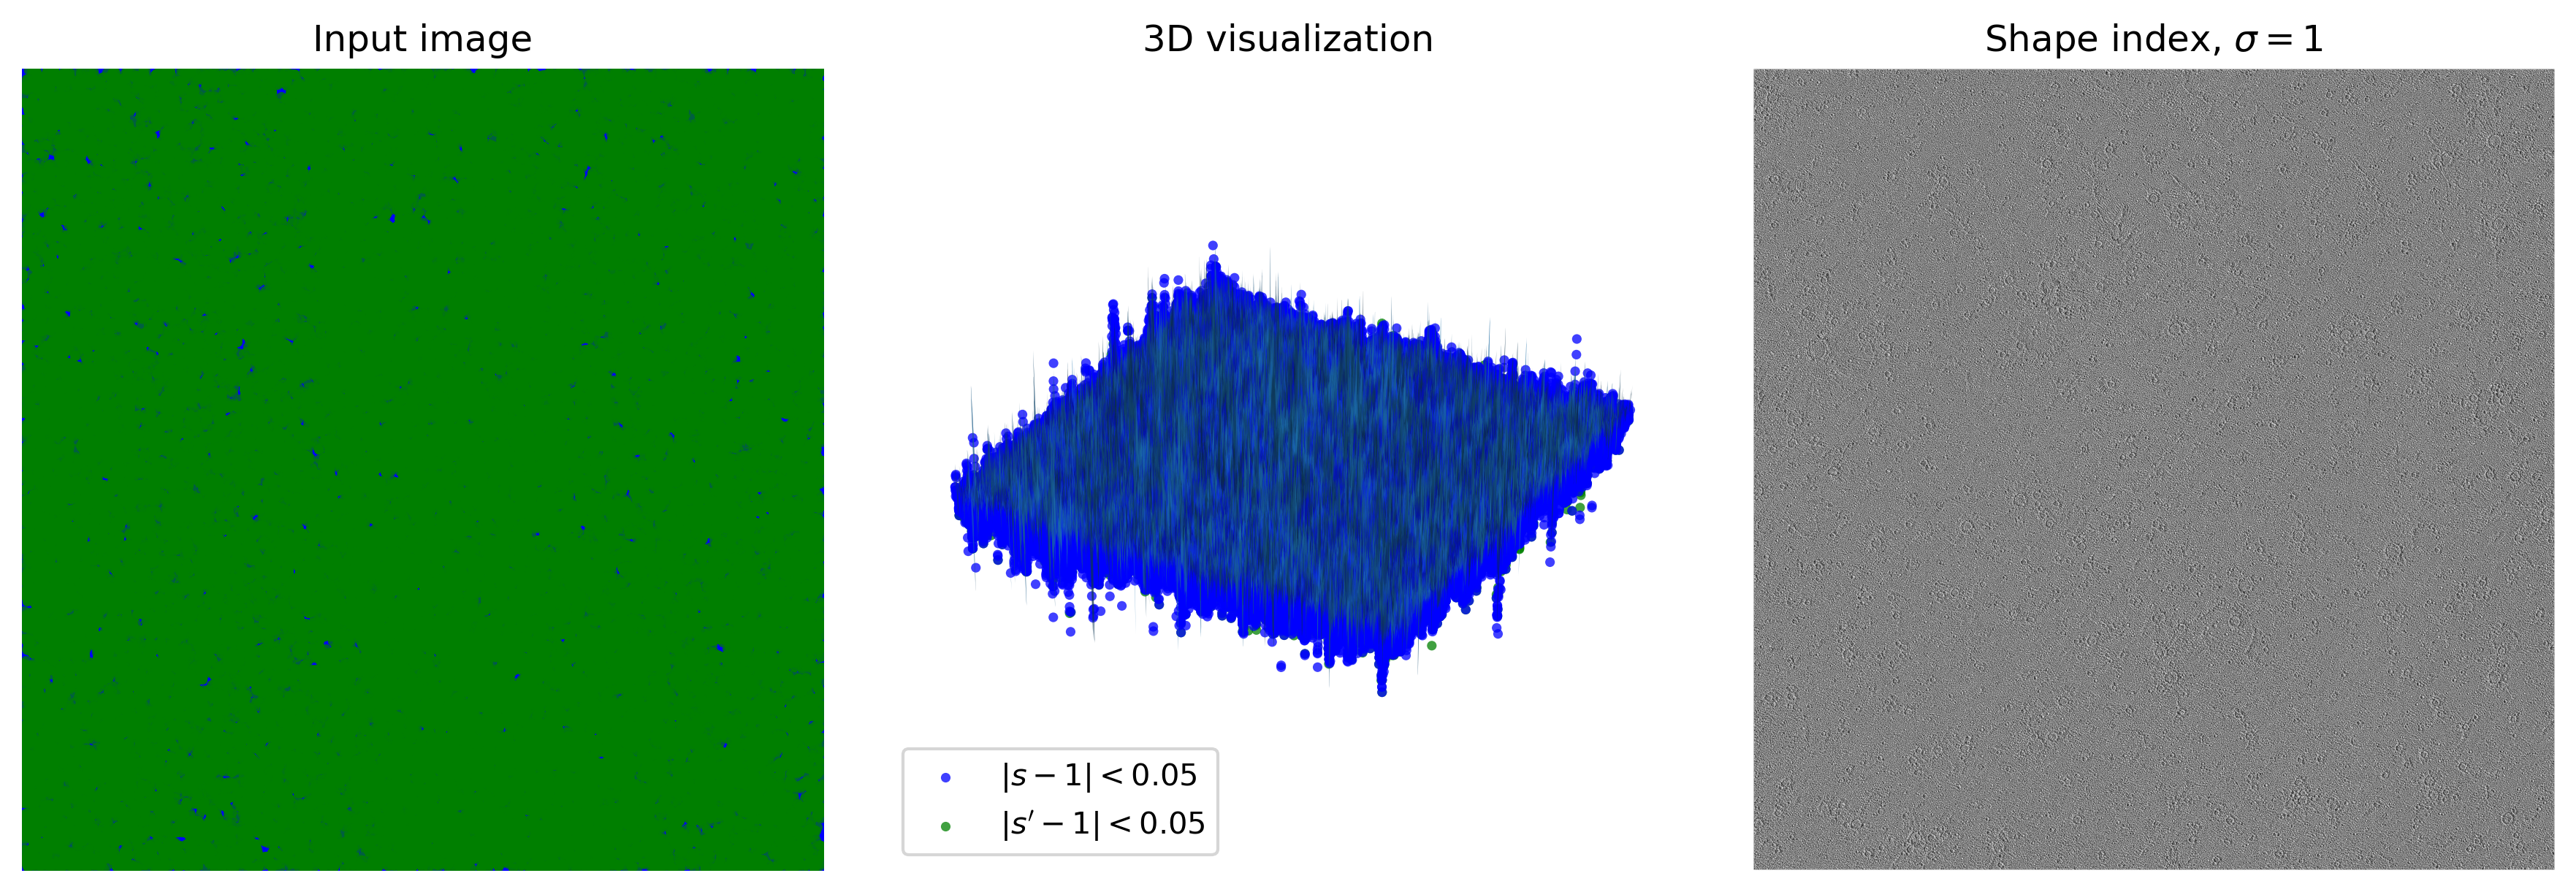

In [14]:
# Looking primarily for spherical cups and ruts
# [ -1, -7/8) = spherical cup
# [-5/8, -3/8) = rut

s = shape_index(image)
target = -0.875
delta = 0.05

# Unsmoothed
point_y, point_x = np.where(np.abs(s - target) < delta)
point_z = image[point_y, point_x]

# Smoothed
s_smooth = ndi.gaussian_filter(s, sigma=0.5)

point_y_s, point_x_s = np.where(np.abs(s_smooth - target) < delta)
point_z_s = image[point_y_s, point_x_s]

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 3, 1)

ax1.imshow(image, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Input image')

scatter_settings = dict(alpha=0.75, s=10, linewidths=0)

ax1.scatter(point_x, point_y, color='blue', **scatter_settings)
ax1.scatter(point_x_s, point_y_s, color='green', **scatter_settings)

ax2 = fig.add_subplot(1, 3, 2, projection='3d', sharex=ax1, sharey=ax1)

x, y = np.meshgrid(
    np.arange(0, image.shape[0], 1),
    np.arange(0, image.shape[1], 1)
)

ax2.plot_surface(x, y, image, linewidth=0, alpha=0.5)

ax2.scatter(
    point_x,
    point_y,
    point_z,
    color='blue',
    label='$|s - 1|<0.05$',
    **scatter_settings
)

ax2.scatter(
    point_x_s,
    point_y_s,
    point_z_s,
    color='green',
    label='$|s\' - 1|<0.05$',
    **scatter_settings
)

ax2.legend(loc='lower left')

ax2.axis('off')
ax2.set_title('3D visualization')

ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)

ax3.imshow(s, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Shape index, $\sigma=1$')

fig.tight_layout()

plt.show()

## Blob Detection

[Source](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html#sphx-glr-auto-examples-features-detection-plot-blob-py)

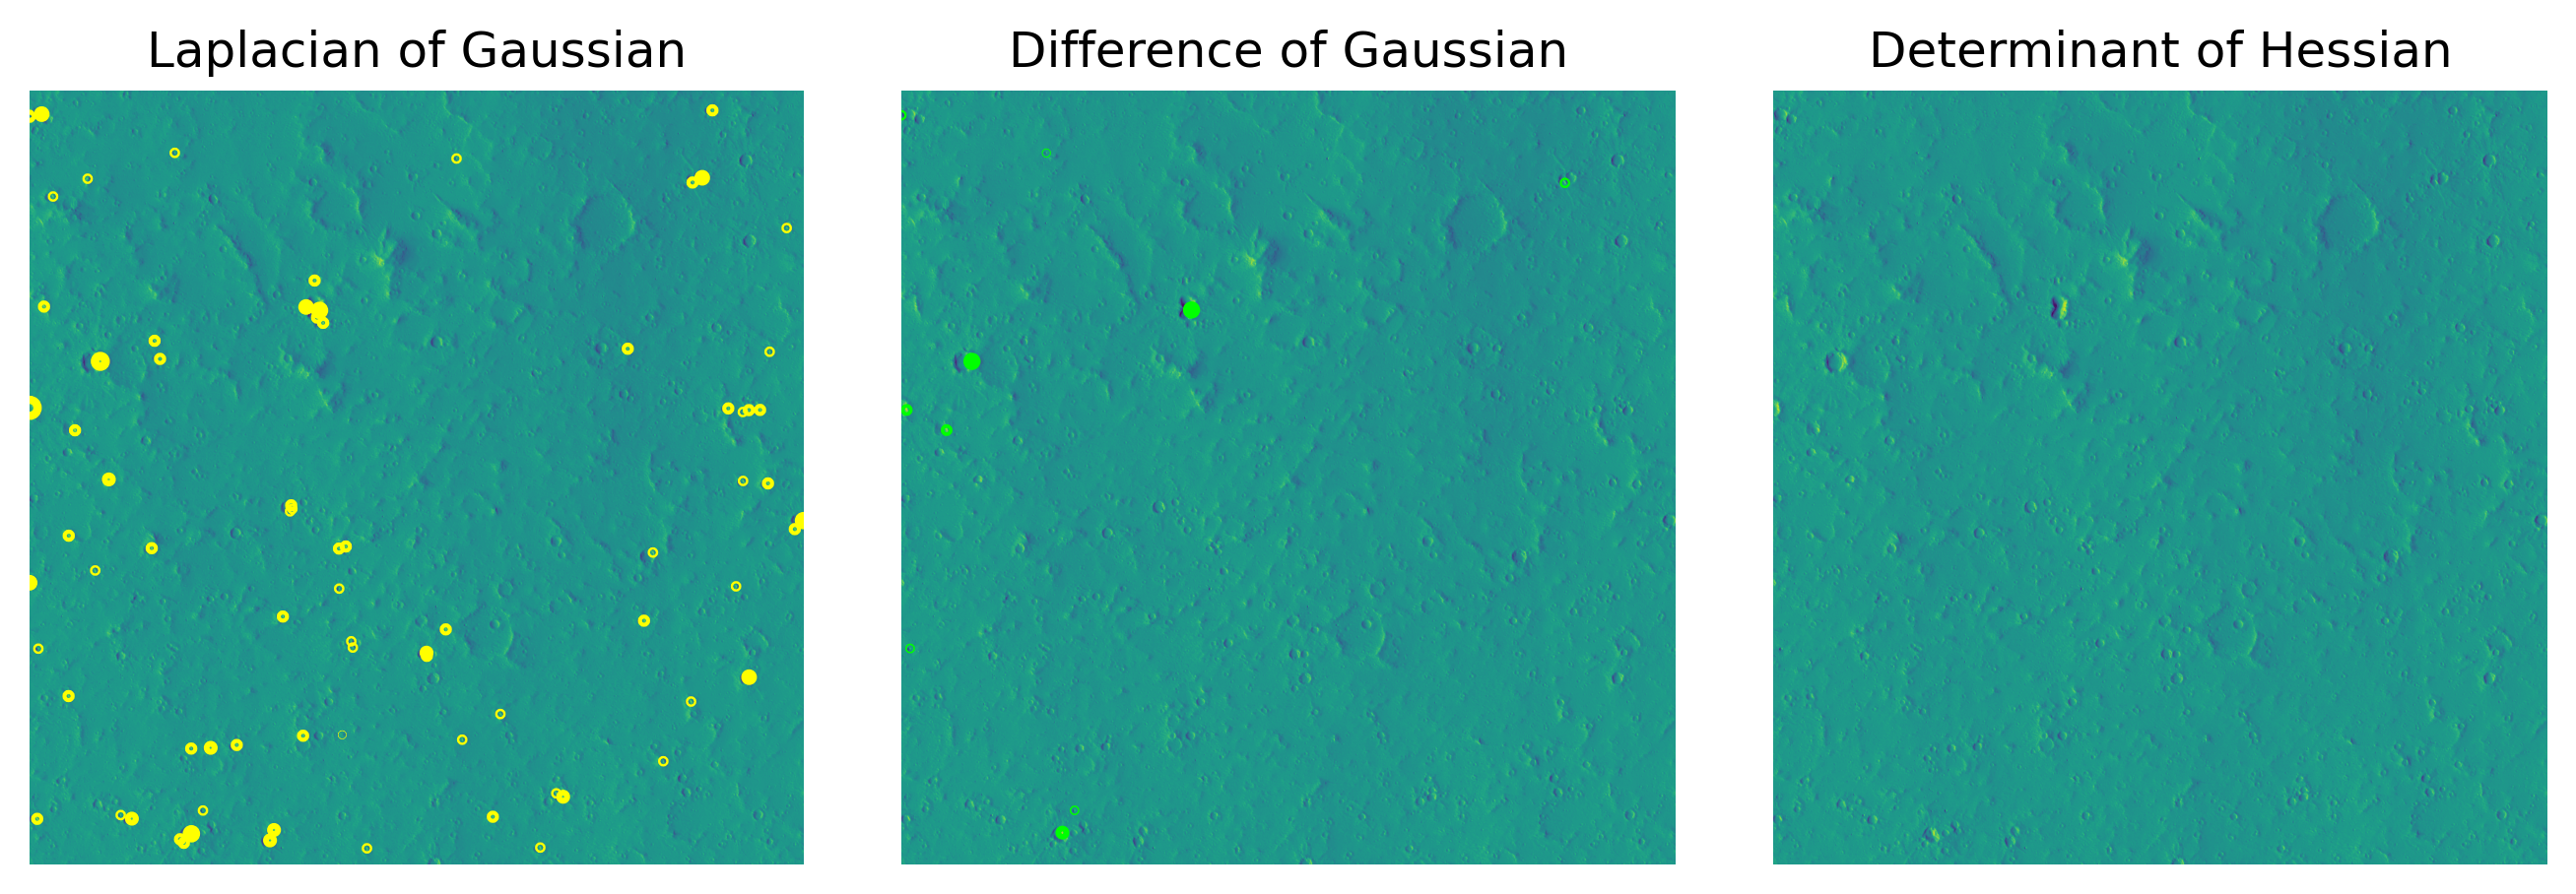

In [3]:
image_gray = image

blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

## Template Matching
[Source](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_template.html#sphx-glr-auto-examples-features-detection-plot-template-py)

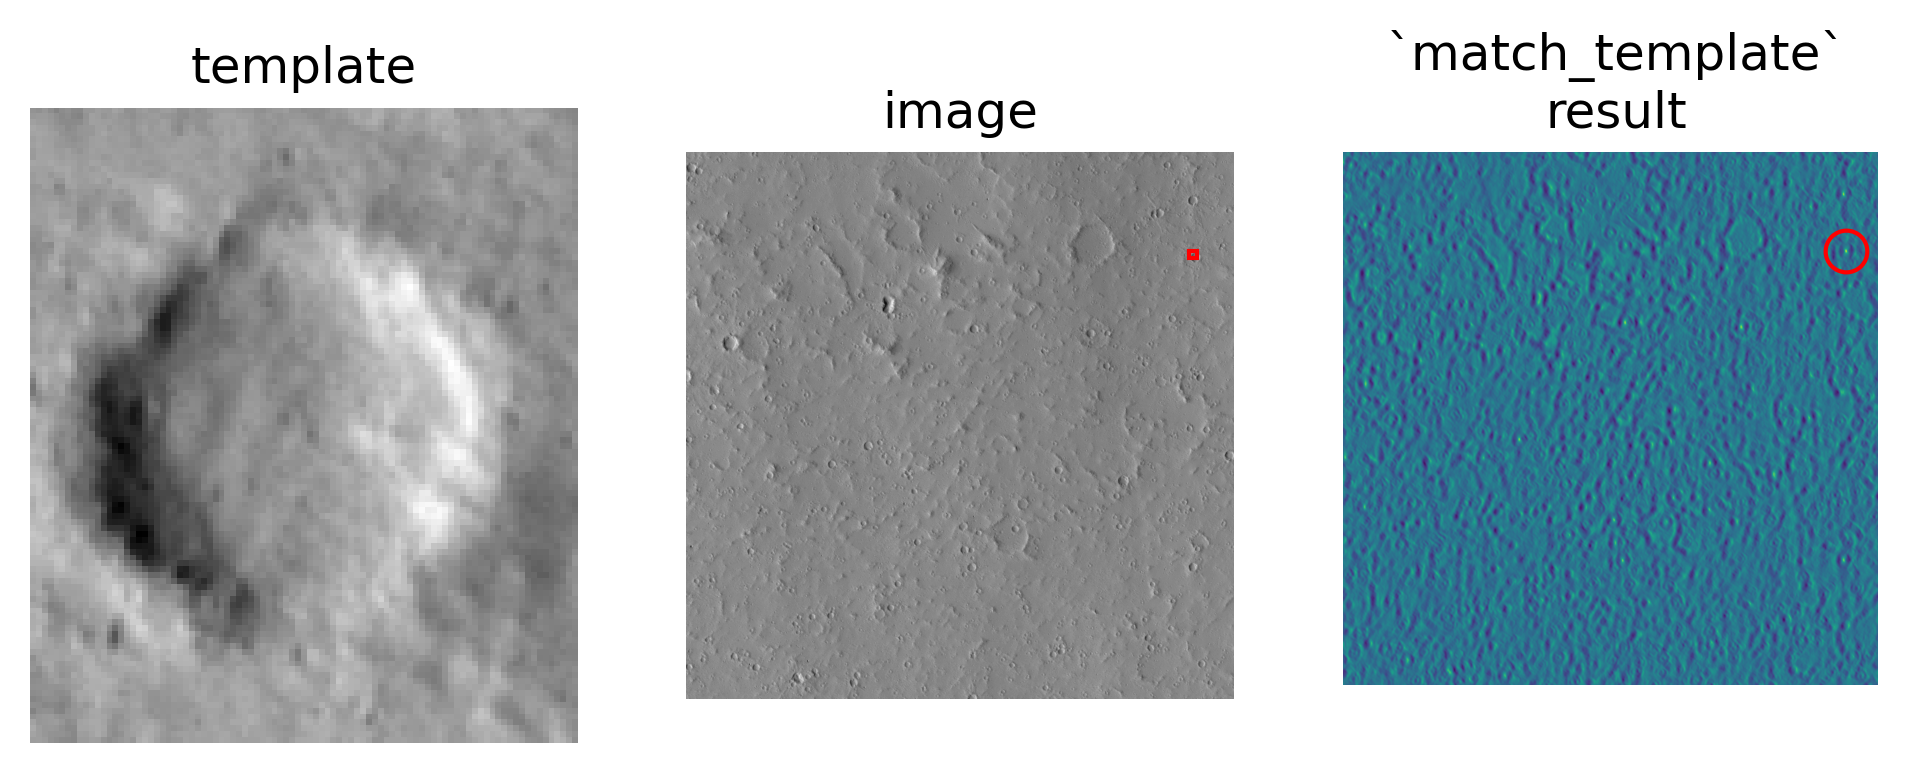

In [25]:
# crater = image[2829:3749, 329:419]
# Slicing rules from: https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/numpy-arrays/indexing-slicing-numpy-arrays/
crater = image[741:849, 3765:3858]

result = match_template(image, crater)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(crater, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(image, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

# Local Maxima
[Source](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html#sphx-glr-auto-examples-segmentation-plot-peak-local-max-py)